# Redistricting - Oregon Congressional

### Code used to generate a sample of redistricting plans that optimize for a plan with less precinct splits

*******************

- Least changes map using 2020 5-year ACS population data
- Proritizing the performance of majority-minority districts using 2020 election data

In [6]:
import maup
import pandas as pd
import geopandas as gp
import random
import json
import warnings
warnings.filterwarnings('ignore')

**Load data**

In [7]:
current_cd = gp.read_file("./raw-data/current_map/district-shapes/POLYGON.shp")
acs_bg_shp = gp.read_file("./raw-data/or_race_2022_bg-acs_shp/or_race_2022_bg.shp")
prec_2020 = gp.read_file("./raw-data/or_vest_20/or_vest_20.shp")
blocks_2020 = gp.read_file("./raw-data/or_pl2020_b/or_pl2020_b.shp")
blocks_cvap_2022 = pd.read_csv("./raw-data/or_cvap_2022_2020_b/or_cvap_2022_2020_b.csv")

In [8]:
current_cd = current_cd.to_crs(epsg=32610)
acs_bg_shp = acs_bg_shp.to_crs(epsg=32610)
prec_2020 = prec_2020.to_crs(epsg=32610)
blocks_2020 = blocks_2020.to_crs(epsg=32610)

current_cd["geometry"] = current_cd.buffer(0)
prec_2020["geometry"] = prec_2020.buffer(0)
blocks_2020["geometry"] = blocks_2020.buffer(0)

In [9]:
# km2
current_cd['area_km2'] = current_cd['geometry'].area/ 10**6 
blocks_2020['area_km2'] = blocks_2020["geometry"].area/ 10**6 

In [60]:
current_cd['area_km2'].sum()

255013.9889689173

In [10]:
### join CVAP data to blocks
blocks_cvap_2022.GEOID20 = blocks_cvap_2022.GEOID20.astype(str)
blocks_2020= blocks_2020.merge(blocks_cvap_2022, on='GEOID20', how='left')

### Prorate data from ACS 2022 Block-Groups to census blocks

In [11]:
pop_columns = [col for col in acs_bg_shp.columns if "22" in col]
bg_to_blocks_assignment = maup.assign(blocks_2020, acs_bg_shp)
# Prorate the ACS totals according to each block's share of the overall block group population:
weights = blocks_2020.P0010001  / bg_to_blocks_assignment.map(blocks_2020.P0010001.groupby(bg_to_blocks_assignment).sum()).fillna(0)
prorated = maup.prorate(bg_to_blocks_assignment, acs_bg_shp[pop_columns], weights)

blocks_2020[pop_columns] = prorated

### Assign blocks to current enacted congressional plan

In [12]:
bg_to_cd = maup.assign(blocks_2020, current_cd)
blocks_2020['current_cd'] = bg_to_cd

In [13]:
# this pretty much matches Dave's Redistricting counts!
blocks_2020.groupby('current_cd').TOT_POP22.sum()

current_cd
0    703293.192844
1    705168.536867
2    700496.347280
3    705867.371823
4    708473.095047
5    706075.456140
Name: TOT_POP22, dtype: float64

### Prorate Election Data from precincts to blocks

In [14]:
# OTHER vote column
prec_2020['G20PREDOTH'] = prec_2020[[col for col in prec_2020.columns if "PRE" in col and col not in ('G20PREDBID', 'G20PRERTRU', 'PRECINCT')]].sum(axis=1)
prec_2020[[col for col in prec_2020.columns if "PRE" in col]]

,PRECINCT,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREPHUN,G20PREOWRI,G20PREDOTH
0,4506,2656,717,30,32,6,24,92
1,4409,1613,473,24,22,11,15,72
2,4404,8264,907,106,68,32,80,286
3,4502,3948,482,49,32,9,27,117
4,4501,9190,785,78,36,18,57,189
...,...,...,...,...,...,...,...,...
1326,201,2656,1465,84,13,2,35,134
1327,435,2335,1608,82,18,8,49,157
1328,425,452,550,15,4,1,9,29
1329,13,1091,2040,58,17,5,18,98


In [15]:
elec_columns = ['G20PREDBID', 'G20PRERTRU', 'G20PREDOTH']
prec_2020[elec_columns] = prec_2020[elec_columns].astype(int)
assignment = maup.assign(blocks_2020, prec_2020)
weights_elec = blocks_2020.P0010001  / assignment.map(blocks_2020.P0010001.groupby(assignment).sum()).fillna(0)
prorated_elec = maup.prorate(assignment, prec_2020[elec_columns], weights_elec)

blocks_2020[elec_columns] = prorated_elec

In [95]:
blocks_2020['CVAP_POC'] = blocks_2020[['CVAP_2OM22', 'CVAP_HSP22', 'CVAP_AIA22', 'CVAP_ASN22', 'CVAP_BLK22']].sum(axis=1)

In [96]:
blocks_2020['CVAP_POC'].sum() / blocks_2020['CVAP_TOT22'].sum()

0.1847760231019207

In [17]:
# blocks_2020.to_file("./output-data/blocks_2020-w_2022_acs_attached.shp")

### MCMC Prep

In [18]:
import networkx as nx
from functools import partial
import matplotlib.pyplot as plt
import json
import numpy as np
plt.style.use('ggplot')

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.tree import bipartition_tree
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import Tally
from gerrychain.constraints import contiguous
from gerrytools.scoring import gingles_districts, demographic_shares, summarize
random.seed(99)

In [19]:
state_abbr = "OH"
state_fip = "39"
num_districts = 6
unique_label = "GEOID20"
pop_col = "TOT_POP22"

In [20]:
# Fill NA values with 0
blocks_2020[blocks_2020.columns[blocks_2020.isna().any()].tolist()] = blocks_2020[blocks_2020.columns[blocks_2020.isna().any()].tolist()].fillna(0)

In [22]:
# need to subset to only necessary columns
blocks_2020_select = blocks_2020[['GEOID20', 'current_cd', 'area_km2', 'TOT_POP22', 'CVAP_TOT22', 'CVAP_POC', 'G20PREDBID', 'G20PRERTRU', 'G20PREDOTH', 'geometry']]

In [23]:
# create graph
graph = Graph.from_geodataframe(blocks_2020_select)
graph.add_data(blocks_2020_select,list(blocks_2020_select))

In [24]:
# population check
TOTPOP = sum(graph.nodes()[n]['TOT_POP22'] for n in graph.nodes())
print(TOTPOP)
blocks_2020.TOT_POP22.sum()

4229373.999999991


4229374.0

In [25]:
### Custom updaters
import polars as pl
class PartValue:
    def __init__(self, col=None, state=state_abbr, num=None):
        self.col = col
        self.state = state
        self.num = num

    def get_val(self, partition):
        return list(map(lambda x: partition.graph.nodes[x].get(self.col), range(blocks_2020.shape[0])))
    
    def new_districts(partition):
        return list(map(lambda x: partition.assignment[x], range(blocks_2020.shape[0])))
    
    def displacement(self, partition):
        c = []
        for inx, (i,j) in enumerate(zip(partition['new_districts'], partition['current_cds'])):
            if int(i) != int(j):
                c.append(partition.graph.nodes[inx].get(self.col))
        return(sum(c))
    
class SavePart:
    def __init__(self, state=state_abbr, num=None, dir = None):
        self.state = state
        self.num = num
        self.dir = dir
        
    def save_assignment(self, partition):
        geos_ids = PartValue(col='GEOID20').get_val(partition)
        new_cds = PartValue.new_districts(partition)
        assignment_df = pl.DataFrame({
                "GEOID20": geos_ids,
                "CD": new_cds}
            )
        output_name = f"{self.state}_part_{str(self.num)}.txt",
        if self.dir is not None:
            output_name = f"{self.dir}/{self.state}_part_{str(self.num)}.txt"
        return(assignment_df.write_csv(output_name, separator=","))


In [26]:
updater = {
    "population": updaters.Tally("TOT_POP22", alias="population"),
    "cvap": updaters.Tally("CVAP_TOT22", alias="cvap"),
    "cvap_poc": updaters.Tally("CVAP_POC", alias="cvap_poc"),
    "2020_pres" : Election("2020_pres", {"G20PRERTRU":"G20PRERTRU","G20PREDBID":"G20PREDBID","G20PREDOTH":"G20PREDOTH"}, alias="2020_pres"),
    "area": updaters.Tally("area_km2", alias="area"),
    "new_districts": PartValue.new_districts,
    "current_cds" : PartValue(col='current_cd').get_val,
    "pop_change" : PartValue(col='TOT_POP22').displacement,
    "area_change" : PartValue(col='area_km2').displacement,
    
}

initial_partition = Partition(
    graph,
    assignment="current_cd",
    updaters=updater
)

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(
    # propose_random_flip,
    recom,
    pop_col="TOT_POP22",
    pop_target=ideal_population,
    epsilon=0.0075,
    node_repeats=2,
    method = partial(
        bipartition_tree,
        max_attempts=5,
        allow_pair_reselection=True 
    )
)

### Area change optimizer -- optimize for plans that minimize area displacement

In [ ]:
area_diff = lambda part: sum([part.graph.nodes[inx].get('area_km2') for inx, (i,j) in enumerate(zip(part['new_districts'], part['current_cds'])) if int(i) != int(j)])

optimizer_area = SingleMetricOptimizer(
    proposal=proposal,
    constraints=[contiguous],
    initial_state=initial_partition,
    optimization_metric=area_diff,
    maximize=False
)

In [ ]:
tot_pop = []
pop_dev = []
cvap_pop = []
cvap_poc = []
pres20d = []
pres20r = []
pres20o = []

areas = []
people_change = []
area_change = []

gingles_scores = []
poc_props = []

dem_seats_pres = []
dem_seats_lean = []
rep_seats_pres = []

t = 0
min_scores_sb = []
with open("./output_area_diff/OR_area_output.jsonl", "w") as f:
    for i, part in enumerate(optimizer_area.short_bursts(5, 4000, with_progress_bar=True)):
        min_scores_sb.append(optimizer_area.best_score)
        
        tot_pop.append(part["population"])
        cvap_pop.append(part["cvap"])
        cvap_poc.append(part["cvap_poc"])
        
        areas.append(part["area"])
        people_change.append(part["pop_change"])
        area_change.append(part["area_change"])
        
        dev = abs((min(part["population"].values()) / ideal_population) - (max(part["population"].values()) / ideal_population))
        pop_dev.append(dev)
        
        pres20d.append(part["2020_pres"].percents("G20PREDBID"))
        pres20r.append(part["2020_pres"].percents("G20PRERTRU"))
        pres20o.append(part["2020_pres"].percents("G20PRERTRU"))
        dem_seats_pres.append(part["2020_pres"].wins("G20PREDBID"))
        rep_seats_pres.append(part["2020_pres"].wins("G20PRERTRU"))
        seat_lean = len([i for i in part["2020_pres"].percents("G20PREDBID") if i <= .55 and i >=.45])
        dem_seats_lean.append(seat_lean)
        
        pp = demographic_shares({"cvap": ["cvap_poc"]})[0].apply(part)
        gd = gingles_districts({"cvap": ["cvap_poc"]}, threshold=0.5)[0].apply(part)
        poc_props.append(pp)
        gingles_scores.append(gd)

        if (gd > 0) or (part["area_change"] < 20000 and dev < .0050 and seat_lean >=2):
            SavePart(num=t, dir='./output_area_diff/').save_assignment(part)
            print(t, gd, part["area_change"], dev, seat_lean)

        data = {
            "step": t,
            "populations": part["population"],
            "areas": part["area"],
            "areas_change": part["area_change"],
            "pops_change":part["pop_change"],
            "cvap_poc_prop": pp,
            "cvap_poc_tot": part["cvap_poc"],
            "cvap_tot": part["cvap"],
            "gingles_districts" : gd,
            "pres20d": part["2020_pres"].percents("G20PREDBID"),
            "pres20r": part["2020_pres"].percents("G20PRERTRU"),
            "pres20o": part["2020_pres"].percents("G20PREDOTH")
        }
            
        # Add newline character to separate entries in JSONL file
        f.write(json.dumps(data) + "\n")
        t +=1

********************************

## Analyze plans

### Load in run stats (if kernal restarted)

In [45]:
with open('./output_area_diff/OR_area_output.jsonl', 'r') as json_file:
    json_list = list(json_file)

In [58]:
# plans sorted by min area displacement with lowest pop deviation
l = []
for idx, i in enumerate(json_list):
  d = pd.json_normalize(json.loads(json_list[idx]))
  pops = dict(d[[i for i in d.columns if "population" in i]].loc[0]).values()
  dev = abs((min(pops) / ideal_population) - (max(pops) / ideal_population))
  areas = dict(d[[i for i in d.columns if "areas" in i]].loc[0]).values()
  if d['areas_change'][0] < 1000 and dev < 0.005:
    l.append({idx:min(areas)})

l.sort(key=lambda x: list(x.values()))
l

[{11252: 115.84395595855632},
 {2771: 277.89018796227884},
 {2091: 457.7258972225499},
 {2092: 531.7010435017036},
 {17516: 550.6003543958708},
 {18071: 551.2729574110577},
 {9086: 552.6082353852908},
 {1121: 623.5493433272443},
 {3963: 658.1429950204761},
 {9297: 765.9733094891262},
 {6657: 799.4008321070664},
 {5226: 846.4850336202813},
 {4936: 863.8417040872273},
 {9498: 879.7927835700775},
 {17181: 957.5633258174967},
 {3446: 961.2319995461366}]

In [80]:
pop_change_list = []
for idx, i in enumerate(json_list):
  d = pd.json_normalize(json.loads(json_list[idx]))
  pops_change = int(d[[i for i in d.columns if "pops_change" in i]].loc[0].iloc[0])
  pop_change_list.append(pops_change)

(array([5.873e+03, 8.140e+02, 5.620e+02, 6.420e+02, 5.710e+02, 7.380e+02,
        6.950e+02, 8.670e+02, 9.800e+02, 1.531e+03, 1.366e+03, 7.320e+02,
        7.360e+02, 7.280e+02, 7.890e+02, 4.740e+02, 3.720e+02, 3.420e+02,
        3.490e+02, 3.520e+02, 1.470e+02, 9.300e+01, 8.800e+01, 7.600e+01,
        3.600e+01, 1.800e+01, 9.000e+00, 1.000e+01, 8.000e+00, 2.000e+00]),
 array([      0. ,  140028.6,  280057.2,  420085.8,  560114.4,  700143. ,
         840171.6,  980200.2, 1120228.8, 1260257.4, 1400286. , 1540314.6,
        1680343.2, 1820371.8, 1960400.4, 2100429. , 2240457.6, 2380486.2,
        2520514.8, 2660543.4, 2800572. , 2940600.6, 3080629.2, 3220657.8,
        3360686.4, 3500715. , 3640743.6, 3780772.2, 3920800.8, 4060829.4,
        4200858. ]),
 <BarContainer object of 30 artists>)

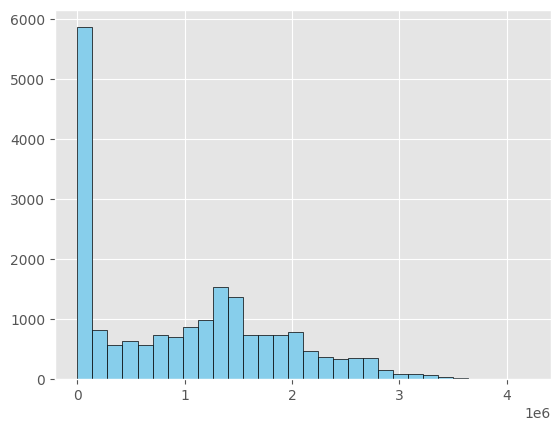

In [81]:
plt.hist(pop_change_list, bins=30, color='skyblue', edgecolor='black')

In [63]:
for idx, i in enumerate(json_list):
  d = pd.json_normalize(json.loads(json_list[idx]))
  if idx==11252:
    pops_change = dict(d[[i for i in d.columns if "pops_change" in i]].loc[0]).values()
    break

In [64]:
pops_change

dict_values([148540.76761843817])

In [46]:
l = []
for idx, i in enumerate(json_list):
  d = pd.json_normalize(json.loads(json_list[idx]))
  pops = dict(d[[i for i in d.columns if "population" in i]].loc[0]).values()
  dev = abs((min(pops) / ideal_population) - (max(pops) / ideal_population))
  cvap_poc_prop = dict(d[[i for i in d.columns if "cvap_poc_prop" in i]].loc[0]).values()
  if d['areas_change'][0] < 5000 and dev < 0.005:
    l.append({idx:max(cvap_poc_prop)})

In [47]:
print(min([max(l[ind].values()) for ind, i in enumerate(l)]))
print(max([max(l[ind].values()) for ind, i in enumerate(l)]))

0.23070290607669847
0.2582785122247732
